# COMPSCIX433.3-018 Python for Data Analysis and Scientific Computing

## Touitter - A project by Matthieu Jacquand and Andrew Pouret


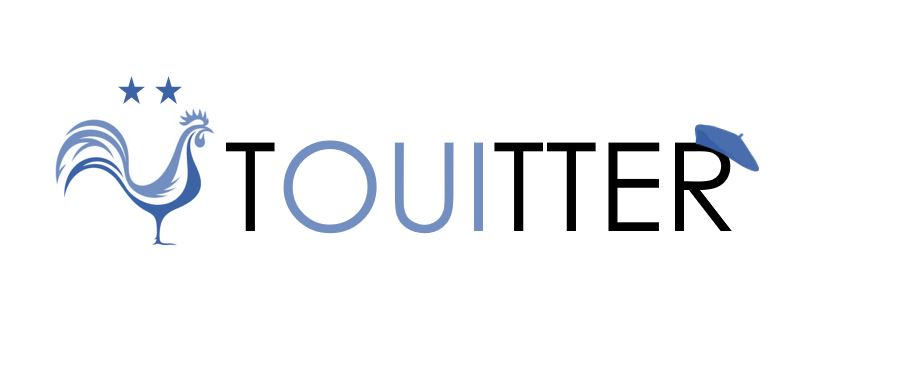

### Project Objective and Data

We often work with numerica data. Indeed, numbers, statistics and probabilities populate many aspects of computer science and the numeric world as a whole. Through this project, we wanted to explore how scientific computing takes place in the domain of natural language processing, or NLP. Our objective is simple :

- Create an algorithm capable of identifying spam and profanity in text messages : ModBot
- Plug our algorithm into a functional web interface ressembling that of today's social networks : Touitter

This project will take us through many aspects of scientific computing. We will see how text data can be imported and then transformed into numeric data in order to be fed to ML models, which python methods are used to treat words and the importance of types along the process. We will also see how our python code will be used by RabbitMQ, the messaging service used for our fake social network.

Our data originates from Kaggle : https://www.kaggle.com/uciml/sms-spam-collection-dataset 
It consists of 5,574 text messages written in English labeled with either 'spam' or 'ham'. Our ModBot's goal is to identify if an input message falls under spam or ham(safe), as well as to pick up on any profanity.

### Dataset Understanding

In [38]:
#first imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from profanity_check import predict as prof_predict
from profanity_check import predict_prob as prof_predict_prob
import seaborn as sns
from collections import Counter

In [2]:
#data lodading
dataset_path = "../dataset/spam.csv"
df = pd.read_csv(dataset_path, sep=",", encoding="latin-1")
df = df.rename(columns={"v1": "class", "v2": "text"})
df = df.drop(df.columns[2:], axis=1)

In [3]:
df.describe()

,class,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Text(0.5, 1.0, 'Message length in characters')

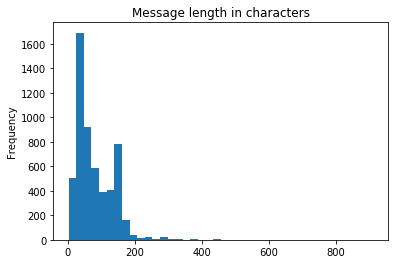

In [4]:
#message length distribution
df['length']=df['text'].apply(len)
df['length'].plot(bins=40,kind='hist').set_title("Message length in characters")

In [5]:
df.head()

,class,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


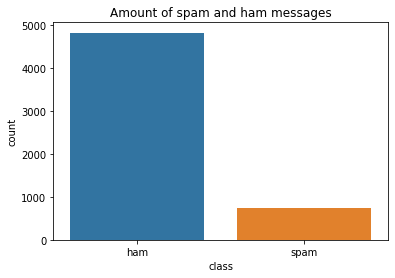

In [6]:
sns.countplot(data = df, x= df["class"]).set_title("Amount of spam and ham messages")
plt.show()

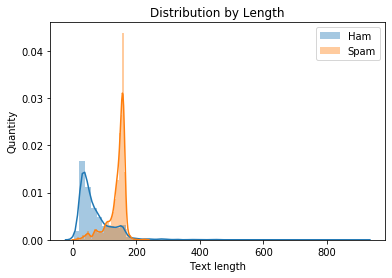

In [7]:
ham =df[df['class'] == 'ham']['text'].str.len()
sns.distplot(ham, label='Ham')
spam = df[df['class'] == 'spam']['text'].str.len()
sns.distplot(spam, label='Spam')
plt.title('Distribution by Length')
plt.xlabel('Text length')
plt.ylabel('Quantity')
plt.legend()

In [8]:
df['class_label'] = df['class']

In [9]:
df['class_label'] = df['class_label'].replace(['ham', 'spam'], [0, 1])

In [10]:
df.head()

,class,text,length,class_label
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0


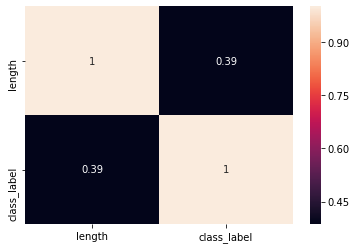

In [11]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [12]:
#wordcounts - difference between mathematical and NLP approach
count1 = Counter(" ".join(df[df['class']=='ham']["text"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of ham", 1 : "count"})
count2 = Counter(" ".join(df[df['class']=='spam']["text"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

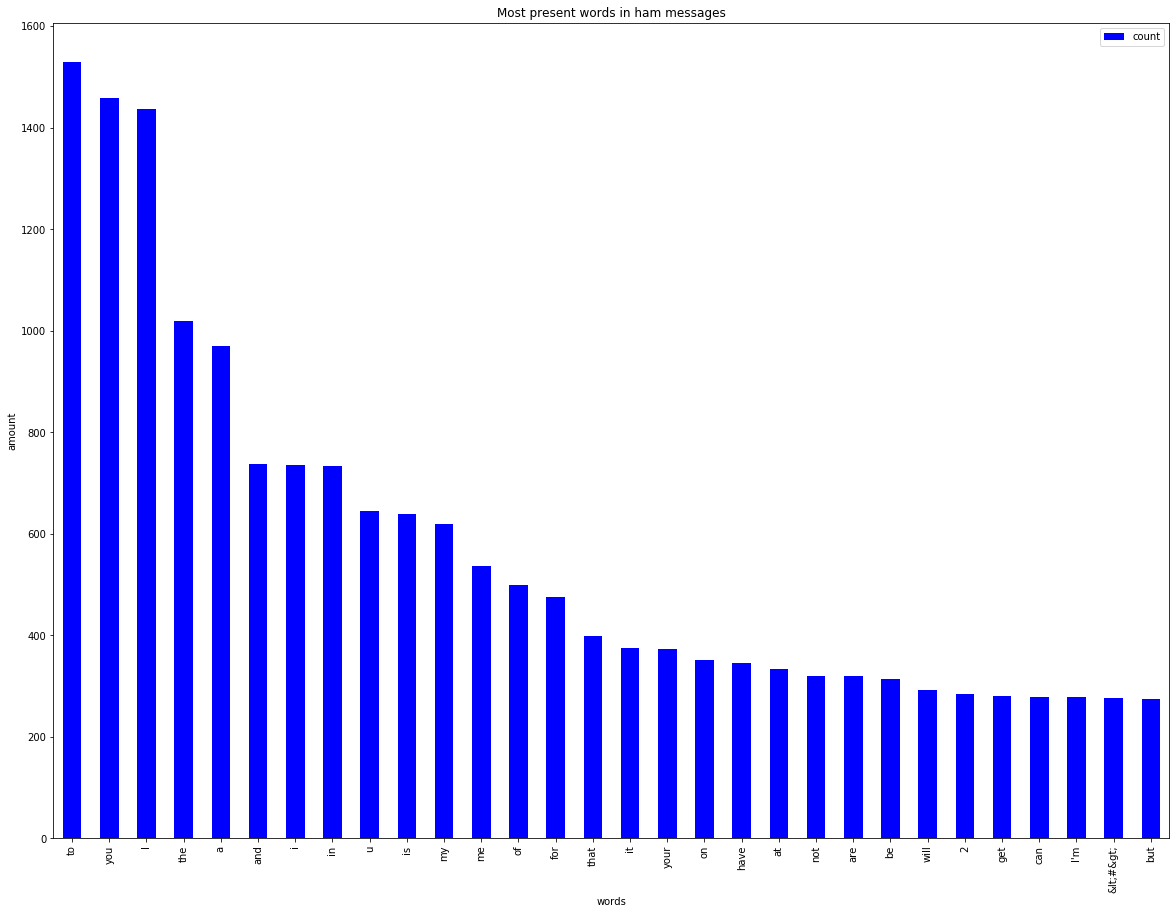

In [13]:
data1.plot.bar(legend = True , color = 'blue',figsize = (20,15))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Most present words in ham messages')
plt.xlabel('words')
plt.ylabel('amount')
plt.show()

Notice the difference between the above graph and the following Wordcloud.

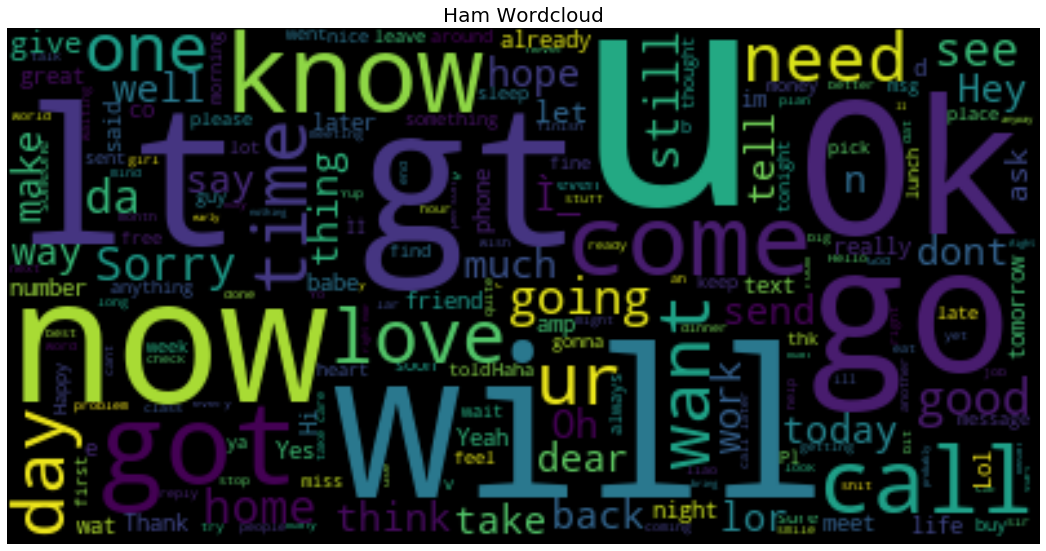

In [35]:
ham_sms = " ".join(df[df['class']=='ham']["text"])

wordcloud = WordCloud().generate(ham_sms)

fig = plt.gcf()
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Ham Wordcloud", fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.axis("off")
plt.show()

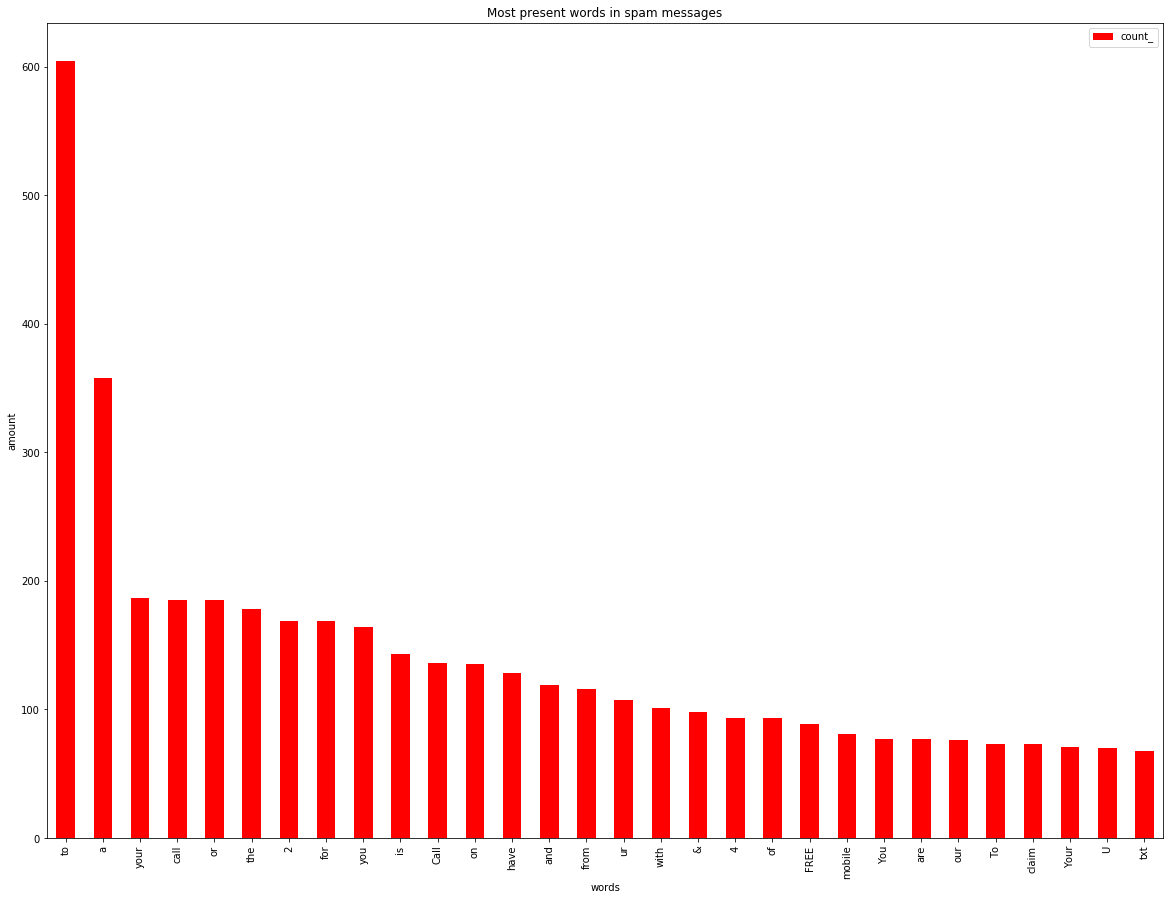

In [14]:
data2.plot.bar(legend = True, color = 'red', figsize = (20,15))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Most present words in spam messages')
plt.xlabel('words')
plt.ylabel('amount')
plt.show()

Once again, note the differences between the above graph and the associated wordcloud.

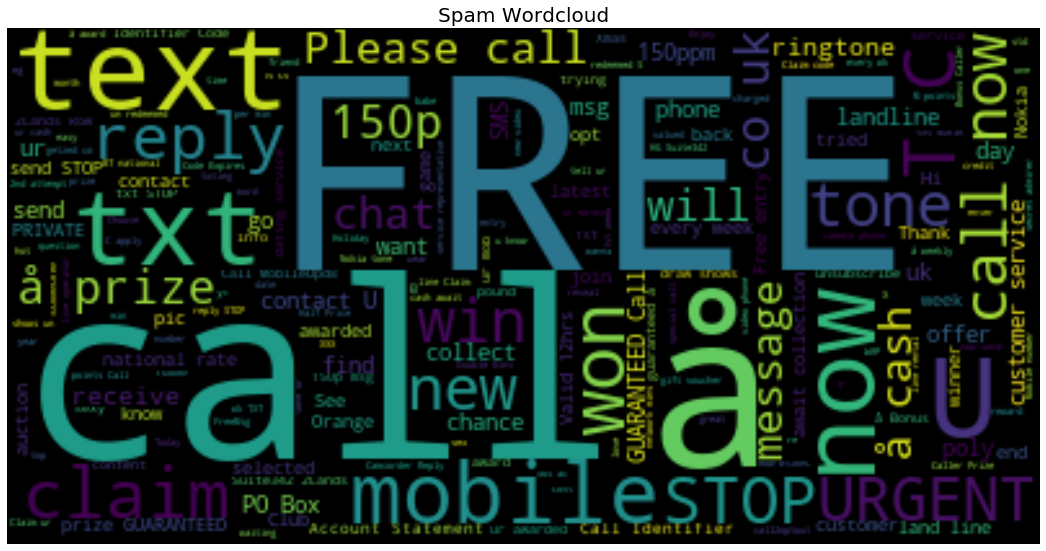

In [37]:
spam_sms = " ".join(df[df['class']=='spam']["text"])

wordcloud = WordCloud().generate(spam_sms)

fig = plt.gcf()
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Spam Wordcloud", fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.axis("off")
plt.show()

### ModBot

In [15]:
df.head()

,class,text,length,class_label
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0


In [16]:
#defining the text processing method to eliminate punctuation and stopwords

import string

from nltk.corpus import stopwords

def text_process(mess):
    nopunc =[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

df['text'].apply(text_process)

0       [Go, jurong, point, crazy, Available, bugis, n...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3           [U, dun, say, early, hor, U, c, already, say]
4       [Nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, U, å£750, Po...
5568                   [Ì, b, going, esplanade, fr, home]
5569                     [Pity, mood, Soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [Rofl, true, name]
Name: text, Length: 5572, dtype: object

In [17]:
#splitting of test and training data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(df['text'],df['class'],test_size=0.2, random_state = 42)

In [18]:
#importing our model and methods

#we choose to work with a multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB


#CountVectorizer converts a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer


#The TfidfTransformer converts a collection of raw documents to a matrix of TF-IDF features. 
# TFIDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus
from sklearn.feature_extraction.text import TfidfTransformer



#result presentation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


cv = CountVectorizer(max_features = 1500)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)

X_test_cv = cv.transform(X_test)

mnb = MultinomialNB(alpha = 0.5)
mnb.fit(X_train_cv,y_train)

y_mnb = mnb.predict(X_test_cv)

print('Naive Bayes Accuracy: ', accuracy_score( y_mnb , y_test))

print('Naive Bayes classification report: ', classification_report(y_mnb, y_test))

Naive Bayes Accuracy:  0.9829596412556054
Naive Bayes classification report:                precision    recall  f1-score   support

         ham       0.99      0.99      0.99       974
        spam       0.91      0.96      0.93       141

    accuracy                           0.98      1115
   macro avg       0.95      0.98      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [19]:
#pipeline creation to accelerate sample predictions

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
   ( 'bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',mnb),
])


pipeline.fit(X_train,y_train)



Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000022C054087B8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True))],
         verbose=False)

In [20]:
#pipeline testing
predictions = pipeline.predict(X_test)
print('Pipelined Naive Bayes accuracy score: ', accuracy_score(y_test,predictions))
print('Pipelined Naive Bayes classification report: ', classification_report(y_test,predictions))

Pipelined Naive Bayes accuracy score:  0.9739910313901345
Pipelined Naive Bayes classification report:                precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       1.00      0.81      0.89       150

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [21]:
#Modbot function !

def ModerateMyTouit(touit):
    sample_spam_predict = pipeline.predict([touit])

    sample_prof_predict_prob = prof_predict_prob([touit])

    my_mod = {'label' : str(sample_spam_predict), 'profanity_score' : float(sample_prof_predict_prob) }
    
    return my_mod
    

In [22]:
#dumping of model and train vectors for RabbitMQ implementation
import joblib

joblib.dump(mnb, 'model.pkl')

['model.pkl']

In [23]:
joblib.dump(X_train, 'X_train.pkl')

['X_train.pkl']

In [24]:
joblib.dump(y_train, 'y_train.pkl')

['y_train.pkl']

### Sample evaluation (profanity warning)

In [25]:
ModerateMyTouit("Man i hate this fucking politician")

{'label': "['ham']", 'profanity_score': 0.8801285794938962}

In [26]:
ModerateMyTouit("Man i hate this stupid politician")

{'label': "['ham']", 'profanity_score': 0.7648308120770626}

In [27]:
ModerateMyTouit("Claim your free iphone here")

{'label': "['spam']", 'profanity_score': 0.06156056646708037}

In [28]:
ModerateMyTouit("Claim your fucking prize")

{'label': "['spam']", 'profanity_score': 0.709215342640642}